**Mount Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Libraries**

In [4]:
!pip install librosa soundfile resampy gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.1 MB/s eta 0:00:00


**Import Libraries**

In [5]:
import os
import librosa
import numpy as np
import pandas as pd
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import joblib


**Load Dataset**

In [6]:
dataset_path = '/content/drive/MyDrive/dataset/ravdess'

**Feature Extraction Function**

In [7]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    mfccs = np.mean(mfcc.T, axis=0)
    chroma_mean = np.mean(chroma.T, axis=0)
    mel_mean = np.mean(mel.T, axis=0)

    return np.hstack([mfccs, chroma_mean, mel_mean])


**Extract Feature**

In [8]:
features = []
labels = []

emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_code = file.split("-")[2]
            emotion = emotion_map.get(emotion_code)
            if emotion:
                features.append(extract_features(file_path))
                labels.append(emotion)


**Preprocess Data (Label Encoding + Scaling)**

In [9]:
X = np.array(features)
y = np.array(labels)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Train/Test Split**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


**Train Model (Random Forest Classifier)**

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Evaluate Model**

In [12]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 92.36%

Classification Report:

              precision    recall  f1-score   support

       angry       0.97      0.97      0.97        67
        calm       0.95      1.00      0.97        75
     disgust       0.84      0.95      0.89        79
     fearful       0.92      0.88      0.90        83
       happy       0.95      0.87      0.91        92
     neutral       1.00      0.94      0.97        33
         sad       0.94      0.91      0.92        64
   surprised       0.88      0.90      0.89        83

    accuracy                           0.92       576
   macro avg       0.93      0.93      0.93       576
weighted avg       0.93      0.92      0.92       576



**Plot Confusion Matrix**

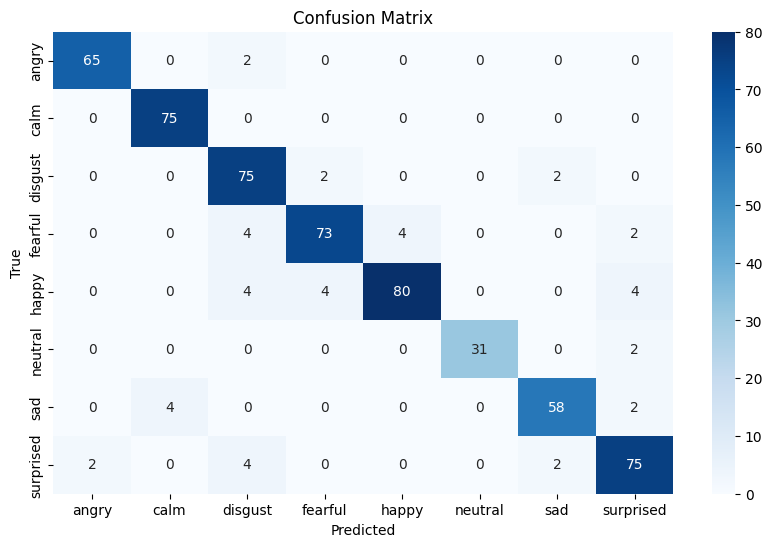

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


 **Save Model and Preprocessors**

In [14]:
joblib.dump(clf, "emotion_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

**Gradio Interface**

In [17]:
import gradio as gr
import librosa
import numpy as np
import joblib

# Extract Features Function
def extract_features_for_gradio(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    mfccs = np.mean(mfcc.T, axis=0)
    chroma_mean = np.mean(chroma.T, axis=0)
    mel_mean = np.mean(mel.T, axis=0)

    return np.hstack([mfccs, chroma_mean, mel_mean])

#Load Model & Preprocessors
clf = joblib.load("emotion_model.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")

#Prediction Function
def predict_emotion_from_audio(file):
    try:
        features = extract_features_for_gradio(file)
        features_scaled = scaler.transform([features])
        prediction = clf.predict(features_scaled)[0]
        emotion = le.inverse_transform([prediction])[0]
        return f"Detected Emotion: {emotion.capitalize()}"
    except Exception as e:
        return f"Error: {e}"

#Welcome message
welcome_message = "**Welcome!**\n\nPlease upload a `.wav` audio file (3–4 seconds) and I'll tell you the speaker's emotion."

#Gradio Interface
interface = gr.Interface(
    fn=predict_emotion_from_audio,
    inputs=gr.Audio(sources=["upload"], type="filepath", label="Upload a .wav audio file"),
    outputs=gr.Text(label="Predicted Emotion"),
    title="Voice Emotion Recognition",
    description="This AI model predicts the **emotion** of a speaker based on their voice.\n\n Upload a `.wav` audio file (3–4 seconds) and see the predicted emotion",
    theme="default",
    examples=None,
    live=False,
)

# Set welcome message as default output
interface.output_component.update(value=welcome_message)

# Launch App
interface.launch(debug=True)


AttributeError: 'Interface' object has no attribute 'output_component'